In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
os.chdir("/home/zongchen/mmd_flow_cubature")

import sys
sys.path.append("/home/zongchen/mmd_flow_cubature")
from mmd_flow.distributions import Distribution
from mmd_flow.kernels import gaussian_kernel
from mmd_flow.mmd import mmd_fixed_target
from mmd_flow.gradient_flow import gradient_flow
import mmd_flow.utils
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

from tqdm import tqdm

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
plt.rc('axes', titlesize=16, labelsize=18, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=18, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

In [5]:
bandwidth = 1.0
kernel = gaussian_kernel(bandwidth)
covariances = jnp.load('data/mog_covs.npy')
means = jnp.load('data/mog_means.npy')
k = 20
weights = jnp.ones(k) / k
dim = 2

In [6]:
# This is neg exponetial
# 

distribution = Distribution(kernel=kernel, means=means, covariances=covariances, integrand_name='neg_exp', weights=weights)
true_value = distribution.integral()

seed_numbers = range(0, 8)  # Adjust this range as needed
particle_num_list = [10, 30, 100, 300, 1000]
step_num_list = [10000, 10000, 10000, 30000, 30000]
I_err_neg_exp = {'iid': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'mmd_flow': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'qmc': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'kh': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))]}
mmd = {'iid': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'mmd_flow': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'qmc': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'kh': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))]}
samples_all = {'iid': {pnum: {} for pnum in particle_num_list}, 'mmd_flow': {pnum: {} for pnum in particle_num_list},
        'qmc': {pnum: {} for pnum in particle_num_list}, 'kh': {pnum: {} for pnum in particle_num_list}}

mmd_func = mmd_fixed_target(None, kernel, distribution)

for e, particle_num in tqdm(enumerate(particle_num_list)):
    for seed in seed_numbers:
        dir_path = f"/home/zongchen/mmd_flow_cubature/results/mmd_flow/mog_dataset/Gaussian_kernel/"
        dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_{step_num_list[e]}__particle_num_{particle_num}__inject_noise_scale_0.1__seed_{seed}/"
        true_value = distribution.integral()
        iid_samples = np.load(dir_path + 'iid_samples.npy')
        mmd_flow_samples = np.load(dir_path + 'mmd_flow_samples.npy')
        qmc_samples = np.load(dir_path + 'qmc_samples.npy')
        if seed == 0:
            samples_all['iid'][particle_num] = iid_samples
            samples_all['mmd_flow'][particle_num] = mmd_flow_samples
            samples_all['qmc'][particle_num] = qmc_samples


        mmd['iid'][0][e, seed] = mmd_func(iid_samples)
        mmd['iid'][1][e, seed] = mmd_func(iid_samples)
        mmd['mmd_flow'][0][e, seed] = mmd_func(mmd_flow_samples)
        mmd['mmd_flow'][1][e, seed] = mmd_func(mmd_flow_samples)
        mmd['qmc'][0][e, seed] = mmd_func(qmc_samples)
        mmd['qmc'][1][e, seed] = mmd_func(qmc_samples)

        I_err_neg_exp['iid'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, iid_samples))
        I_err_neg_exp['iid'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, iid_samples))
        I_err_neg_exp['mmd_flow'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, mmd_flow_samples))
        I_err_neg_exp['mmd_flow'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, mmd_flow_samples))
        I_err_neg_exp['qmc'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, qmc_samples))
        I_err_neg_exp['qmc'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, qmc_samples))

        dir_path = f"/home/zongchen/mmd_flow_cubature/results/kernel_herding/mog_dataset/Gaussian_kernel/"
        dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__seed_{seed}/"

        kh_samples = np.load(dir_path + 'kernel_herding_samples.npy')
        if seed == 0:
            samples_all['kh'][particle_num] = kh_samples
        mmd['kh'][0][e, seed] = mmd_func(kh_samples)
        mmd['kh'][1][e, seed] = mmd_func(kh_samples)
        I_err_neg_exp['kh'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, kh_samples))
        I_err_neg_exp['kh'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, kh_samples))

kt_particle_num_list = [16, 32, 64, 128, 256]
I_err_neg_exp['kt'] = [np.zeros((len(kt_particle_num_list), len(seed_numbers))), np.zeros((len(kt_particle_num_list), len(seed_numbers)))]
mmd['kt'] = [np.zeros((len(kt_particle_num_list), len(seed_numbers))), np.zeros((len(kt_particle_num_list), len(seed_numbers)))]
samples_all['kt'] = {pnum: {} for pnum in kt_particle_num_list}

for e, particle_num in enumerate(kt_particle_num_list):
    for seed in seed_numbers:
        dir_path = f"/home/zongchen/mmd_flow_cubature/results/kernel_thinning/mog_dataset/Gaussian_kernel/"
        dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}/"

        kt_samples = np.load(dir_path + 'kt_samples.npy')
        if seed == 0:
            samples_all['kt'][particle_num] = kt_samples
        mmd['kt'][0][e, seed] = mmd_func(kt_samples)
        mmd['kt'][1][e, seed] = mmd_func(kt_samples)
        I_err_neg_exp['kt'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, kt_samples))
        I_err_neg_exp['kt'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, kt_samples))


5it [00:53, 10.79s/it]


In [7]:
# This is square function
# 
distribution = Distribution(kernel=kernel, means=means, covariances=covariances, integrand_name='square', weights=weights)
true_value = distribution.integral()

seed_numbers = range(0, 8)  # Adjust this range as needed
particle_num_list = [10, 30, 100, 300, 1000]
step_num_list = [10000, 10000, 10000, 30000, 30000]
I_err_square = {'iid': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'mmd_flow': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'qmc': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))],
        'kh': [np.zeros((len(particle_num_list), len(seed_numbers))), np.zeros((len(particle_num_list), len(seed_numbers)))]}

for e, particle_num in enumerate(particle_num_list):
    for seed in seed_numbers:
        dir_path = f"/home/zongchen/mmd_flow_cubature/results/mmd_flow/mog_dataset/Gaussian_kernel/"
        dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_{step_num_list[e]}__particle_num_{particle_num}__inject_noise_scale_0.1__seed_{seed}/"
        true_value = distribution.integral()
        iid_samples = np.load(dir_path + 'iid_samples.npy')
        mmd_flow_samples = np.load(dir_path + 'mmd_flow_samples.npy')
        qmc_samples = np.load(dir_path + 'qmc_samples.npy')

        I_err_square['iid'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, iid_samples))
        I_err_square['iid'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, iid_samples))
        I_err_square['mmd_flow'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, mmd_flow_samples))
        I_err_square['mmd_flow'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, mmd_flow_samples))
        I_err_square['qmc'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, qmc_samples))
        I_err_square['qmc'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, qmc_samples))

        dir_path = f"/home/zongchen/mmd_flow_cubature/results/kernel_herding/mog_dataset/Gaussian_kernel/"
        dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__seed_{seed}/"

        kh_samples = np.load(dir_path + 'kernel_herding_samples.npy')
        I_err_square['kh'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, kh_samples))
        I_err_square['kh'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, kh_samples))

kt_particle_num_list = [16, 32, 64, 128, 256]
I_err_square['kt'] = [np.zeros((len(kt_particle_num_list), len(seed_numbers))), np.zeros((len(kt_particle_num_list), len(seed_numbers)))]
for e, particle_num in enumerate(kt_particle_num_list):
    for seed in seed_numbers:
        dir_path = f"/home/zongchen/mmd_flow_cubature/results/kernel_thinning/mog_dataset/Gaussian_kernel/"
        dir_path += f"__step_size_1.0__bandwidth_1.0__step_num_10000__particle_num_{particle_num}__inject_noise_scale_0.0__seed_{seed}/"

        kt_samples = np.load(dir_path + 'kt_samples.npy')
        I_err_square['kt'][0][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, kt_samples))
        I_err_square['kt'][1][e, seed] = np.abs(true_value - mmd_flow.utils.evaluate_integral(distribution, kt_samples))


In [8]:
I_err_neg_exp['iid'][0] = np.nanmean(I_err_neg_exp['iid'][0], axis=1)
I_err_neg_exp['iid'][1] = np.nanstd(I_err_neg_exp['iid'][1], axis=1) / np.sqrt(I_err_neg_exp['iid'][1].shape[1])
I_err_neg_exp['mmd_flow'][0] = np.nanmean(I_err_neg_exp['mmd_flow'][0], axis=1)
I_err_neg_exp['mmd_flow'][1] = np.nanstd(I_err_neg_exp['mmd_flow'][1], axis=1) / np.sqrt(I_err_neg_exp['mmd_flow'][1].shape[1])
I_err_neg_exp['kh'][0] = np.nanmean(I_err_neg_exp['kh'][0], axis=1)
I_err_neg_exp['kh'][1] = np.nanstd(I_err_neg_exp['kh'][1], axis=1) / np.sqrt(I_err_neg_exp['kh'][1].shape[1])
I_err_neg_exp['qmc'][0] = np.nanmean(I_err_neg_exp['qmc'][0], axis=1)
I_err_neg_exp['qmc'][1] = np.nanstd(I_err_neg_exp['qmc'][1], axis=1) / np.sqrt(I_err_neg_exp['qmc'][1].shape[1])
I_err_neg_exp['kt'][0] = np.nanmean(I_err_neg_exp['kt'][0], axis=1)
I_err_neg_exp['kt'][1] = np.nanstd(I_err_neg_exp['kt'][1], axis=1) / np.sqrt(I_err_neg_exp['kt'][1].shape[1])

In [9]:
I_err_square['iid'][0] = np.nanmean(I_err_square['iid'][0], axis=1)
I_err_square['iid'][1] = np.nanstd(I_err_square['iid'][1], axis=1) / np.sqrt(I_err_square['iid'][1].shape[1])
I_err_square['mmd_flow'][0] = np.nanmean(I_err_square['mmd_flow'][0], axis=1)
I_err_square['mmd_flow'][1] = np.nanstd(I_err_square['mmd_flow'][1], axis=1) / np.sqrt(I_err_square['mmd_flow'][1].shape[1])
I_err_square['kh'][0] = np.nanmean(I_err_square['kh'][0], axis=1)
I_err_square['kh'][1] = np.nanstd(I_err_square['kh'][1], axis=1) / np.sqrt(I_err_square['kh'][1].shape[1])
I_err_square['qmc'][0] = np.nanmean(I_err_square['qmc'][0], axis=1)
I_err_square['qmc'][1] = np.nanstd(I_err_square['qmc'][1], axis=1) / np.sqrt(I_err_square['qmc'][1].shape[1])
I_err_square['kt'][0] = np.nanmean(I_err_square['kt'][0], axis=1)
I_err_square['kt'][1] = np.nanstd(I_err_square['kt'][1], axis=1) / np.sqrt(I_err_square['kt'][1].shape[1])

In [10]:
mmd['iid'][0] = np.nanmean(mmd['iid'][0], axis=1)
mmd['iid'][1] = np.nanstd(mmd['iid'][1], axis=1) / np.sqrt(mmd['iid'][1].shape[1])
mmd['mmd_flow'][0] = np.nanmean(mmd['mmd_flow'][0], axis=1)
mmd['mmd_flow'][1] = np.nanstd(mmd['mmd_flow'][1], axis=1) / np.sqrt(mmd['mmd_flow'][1].shape[1])
mmd['kh'][0] = np.nanmean(mmd['kh'][0], axis=1)
mmd['kh'][1] = np.nanstd(mmd['kh'][1], axis=1) / np.sqrt(mmd['kh'][1].shape[1])
mmd['qmc'][0] = np.nanmean(mmd['qmc'][0], axis=1)
mmd['qmc'][1] = np.nanstd(mmd['qmc'][1], axis=1) / np.sqrt(mmd['qmc'][1].shape[1])
mmd['kt'][0] = np.nanmean(mmd['kt'][0], axis=1)
mmd['kt'][1] = np.nanstd(mmd['kt'][1], axis=1) / np.sqrt(mmd['kt'][1].shape[1])

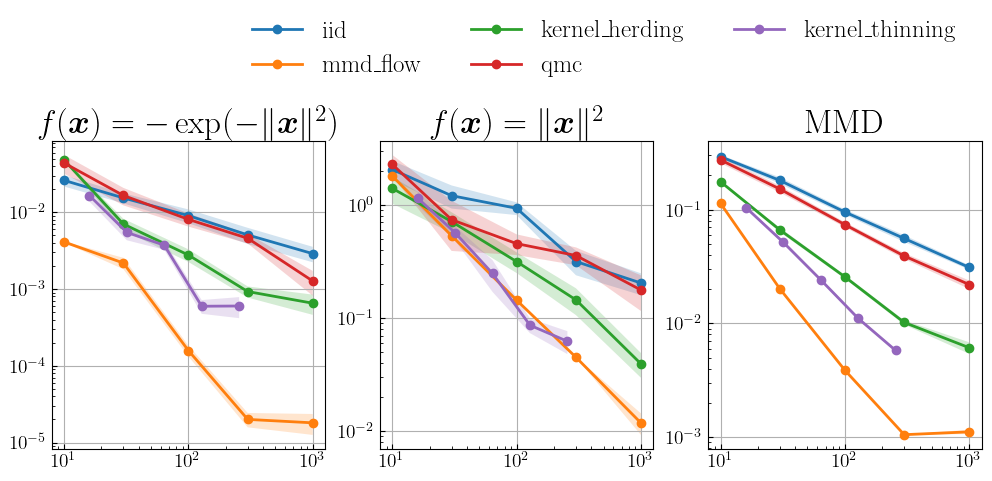

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].grid(True)
axs[0].plot(particle_num_list, I_err_neg_exp['iid'][0], label='iid', marker='o')
axs[0].fill_between(particle_num_list, I_err_neg_exp['iid'][0] - I_err_neg_exp['iid'][1], I_err_neg_exp['iid'][0] + I_err_neg_exp['iid'][1], alpha=0.2)
axs[0].plot(particle_num_list, I_err_neg_exp['mmd_flow'][0], label='mmd_flow', marker='o')
axs[0].fill_between(particle_num_list, I_err_neg_exp['mmd_flow'][0] - I_err_neg_exp['mmd_flow'][1], I_err_neg_exp['mmd_flow'][0] + I_err_neg_exp['mmd_flow'][1], alpha=0.2)
axs[0].plot(particle_num_list, I_err_neg_exp['kh'][0], label='kernel_herding', marker='o')
axs[0].fill_between(particle_num_list, I_err_neg_exp['kh'][0] - I_err_neg_exp['kh'][1], I_err_neg_exp['kh'][0] + I_err_neg_exp['kh'][1], alpha=0.2)
axs[0].plot(particle_num_list, I_err_neg_exp['qmc'][0], label='qmc', marker='o')
axs[0].fill_between(particle_num_list, I_err_neg_exp['qmc'][0] - I_err_neg_exp['qmc'][1], I_err_neg_exp['qmc'][0] + I_err_neg_exp['qmc'][1], alpha=0.2)
axs[0].plot(kt_particle_num_list, I_err_neg_exp['kt'][0], label='kernel_thinning', marker='o')
axs[0].fill_between(kt_particle_num_list, I_err_neg_exp['kt'][0] - I_err_neg_exp['kt'][1], I_err_neg_exp['kt'][0] + I_err_neg_exp['kt'][1], alpha=0.2)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_title(r'$f(\boldsymbol{x}) = -\exp(-\|\boldsymbol{x}\|^2)$')

axs[1].grid(True)
axs[1].plot(particle_num_list, I_err_square['iid'][0], label='iid', marker='o')
axs[1].fill_between(particle_num_list, I_err_square['iid'][0] - I_err_square['iid'][1], I_err_square['iid'][0] + I_err_square['iid'][1], alpha=0.2)
axs[1].plot(particle_num_list, I_err_square['mmd_flow'][0], label='mmd_flow', marker='o')
axs[1].fill_between(particle_num_list, I_err_square['mmd_flow'][0] - I_err_square['mmd_flow'][1], I_err_square['mmd_flow'][0] + I_err_square['mmd_flow'][1], alpha=0.2)
axs[1].plot(particle_num_list, I_err_square['kh'][0], label='kernel_herding', marker='o')
axs[1].fill_between(particle_num_list, I_err_square['kh'][0] - I_err_square['kh'][1], I_err_square['kh'][0] + I_err_square['kh'][1], alpha=0.2)
axs[1].plot(particle_num_list, I_err_square['qmc'][0], label='qmc', marker='o')
axs[1].fill_between(particle_num_list, I_err_square['qmc'][0] - I_err_square['qmc'][1], I_err_square['qmc'][0] + I_err_square['qmc'][1], alpha=0.2)
axs[1].plot(kt_particle_num_list, I_err_square['kt'][0], label='kernel_thinning', marker='o')
axs[1].fill_between(kt_particle_num_list, I_err_square['kt'][0] - I_err_square['kt'][1], I_err_square['kt'][0] + I_err_square['kt'][1], alpha=0.2)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_title(r'$f(\boldsymbol{x}) = \|\boldsymbol{x}\|^2$')

axs[2].grid(True)
axs[2].plot(particle_num_list, mmd['iid'][0], label='iid', marker='o')
axs[2].fill_between(particle_num_list, mmd['iid'][0] - mmd['iid'][1], mmd['iid'][0] + mmd['iid'][1], alpha=0.2)
axs[2].plot(particle_num_list, mmd['mmd_flow'][0], label='mmd_flow', marker='o')
axs[2].fill_between(particle_num_list, mmd['mmd_flow'][0] - mmd['mmd_flow'][1], mmd['mmd_flow'][0] + mmd['mmd_flow'][1], alpha=0.2)
axs[2].plot(particle_num_list, mmd['kh'][0], label='kernel_herding', marker='o')
axs[2].fill_between(particle_num_list, mmd['kh'][0] - mmd['kh'][1], mmd['kh'][0] + mmd['kh'][1], alpha=0.2)
axs[2].plot(particle_num_list, mmd['qmc'][0], label='qmc', marker='o')
axs[2].fill_between(particle_num_list, mmd['qmc'][0] - mmd['qmc'][1], mmd['qmc'][0] + mmd['qmc'][1], alpha=0.2)
axs[2].plot(kt_particle_num_list, mmd['kt'][0], label='kernel_thinning', marker='o')
axs[2].fill_between(kt_particle_num_list, mmd['kt'][0] - mmd['kt'][1], mmd['kt'][0] + mmd['kt'][1], alpha=0.2)
axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_title('MMD')
axs[2].legend(bbox_to_anchor=(-1.75, 1.3), loc='center left', ncol=3)

plt.show()

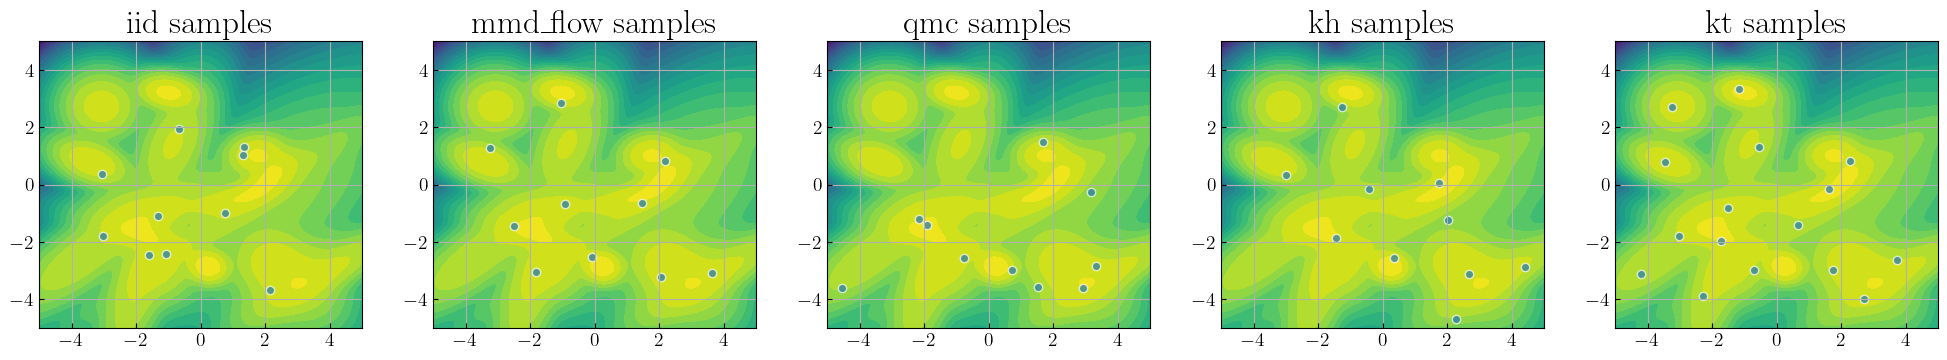

In [24]:
# Visualize the samples
x_range = (-5, 5)
y_range = (-5, 5)
resolution = 100
x_vals = jnp.linspace(x_range[0], x_range[1], resolution)
y_vals = jnp.linspace(y_range[0], y_range[1], resolution)
X, Y = jnp.meshgrid(x_vals, y_vals)
grid = jnp.stack([X.ravel(), Y.ravel()], axis=1)
logpdf = jnp.log(distribution.pdf(grid).reshape(resolution, resolution))

fig, axs = plt.subplots(1, len(samples_all), figsize=(4 * len(samples_all), 4))
for ax, (method, samples) in zip(axs, samples_all.items()):
    if method == 'kt':
        number = 16
    else:
        number = 10
    contour = ax.contourf(X, Y, logpdf, levels=20, cmap='viridis')
    ax.scatter(samples[number][:, 0], samples[number][:, 1], label=method, alpha=0.7, edgecolors='white')
    ax.set_title(f"{method} samples")

plt.tight_layout()
plt.show()


In [ ]:
samples

{30: array([[ 1.34946814,  1.31849941],
        [-1.08018023, -2.43418421],
        [ 0.74050357, -0.98520881],
        [ 1.30231498,  1.02309096],
        [-3.07251443,  0.3857702 ],
        [-1.31107322, -1.08006009],
        [ 2.15092588, -3.68923302],
        [-1.60168018, -2.46881179],
        [-0.68127742,  1.92769652],
        [-3.04258095, -1.80153531],
        [ 1.66054552,  0.83245796],
        [ 1.54914772, -0.89777465],
        [-2.26429118, -4.29550868],
        [ 1.24107034, -1.81092116],
        [-2.04327344, -0.9401859 ],
        [-2.1006543 , -4.03407523],
        [ 1.71189688, -0.2963328 ],
        [-1.84355403, -0.67000067],
        [-2.18655373, -4.25173376],
        [ 2.48339012, -3.10483193],
        [-1.2683039 ,  1.55118028],
        [-2.90815773,  2.49805331],
        [-2.84961622,  1.12312537],
        [-1.71142002, -3.18169159],
        [-1.73159715, -2.16267108],
        [ 2.41956668, -2.7025459 ],
        [-3.21488713,  1.21250739],
        [-2.00987603, -1